# Analysis of drifting grating stimulus

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from bluepy import Cell, Synapse, Circuit, Simulation
import os
import json
from helper_functions import load_sim_results, get_activity, plot_PSTH, get_single_cell_psths, detect_rate_peaks
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [3]:
sims_file = '/gpfs/bbp.cscs.ch/data/scratch/proj83/bbp_workflow/6f0a9a9b-842b-4874-8b16-6c6010c07ace/analyses/simulations.pkl'
sims = pd.read_pickle(sims_file)

save_path = os.path.join(os.path.split(sims_file)[0], 'visual_contrast_analysis')
if not os.path.exists(save_path):
    os.makedirs(save_path)

In [3]:
# TODO: EXC/INH peak statistics
#       EXC/INH tuning

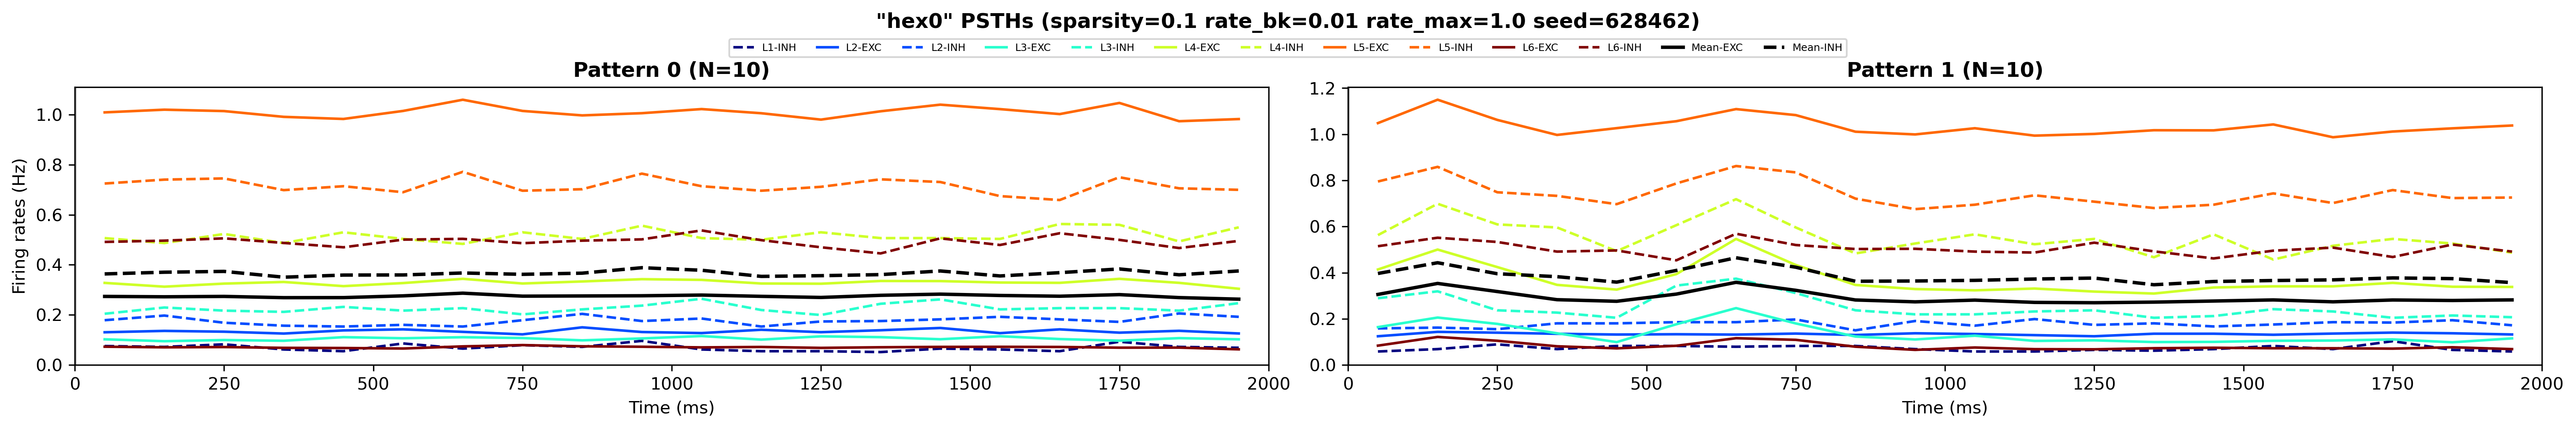

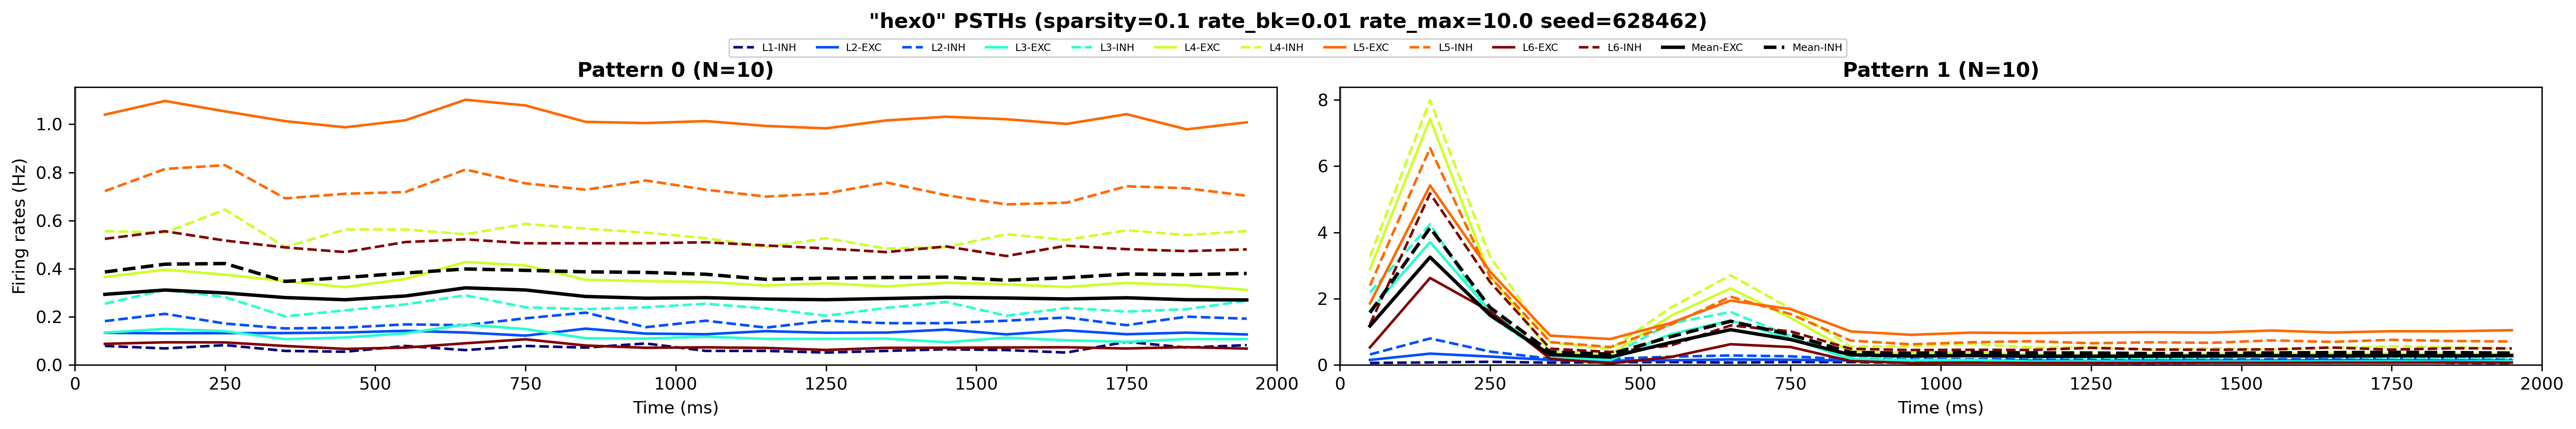

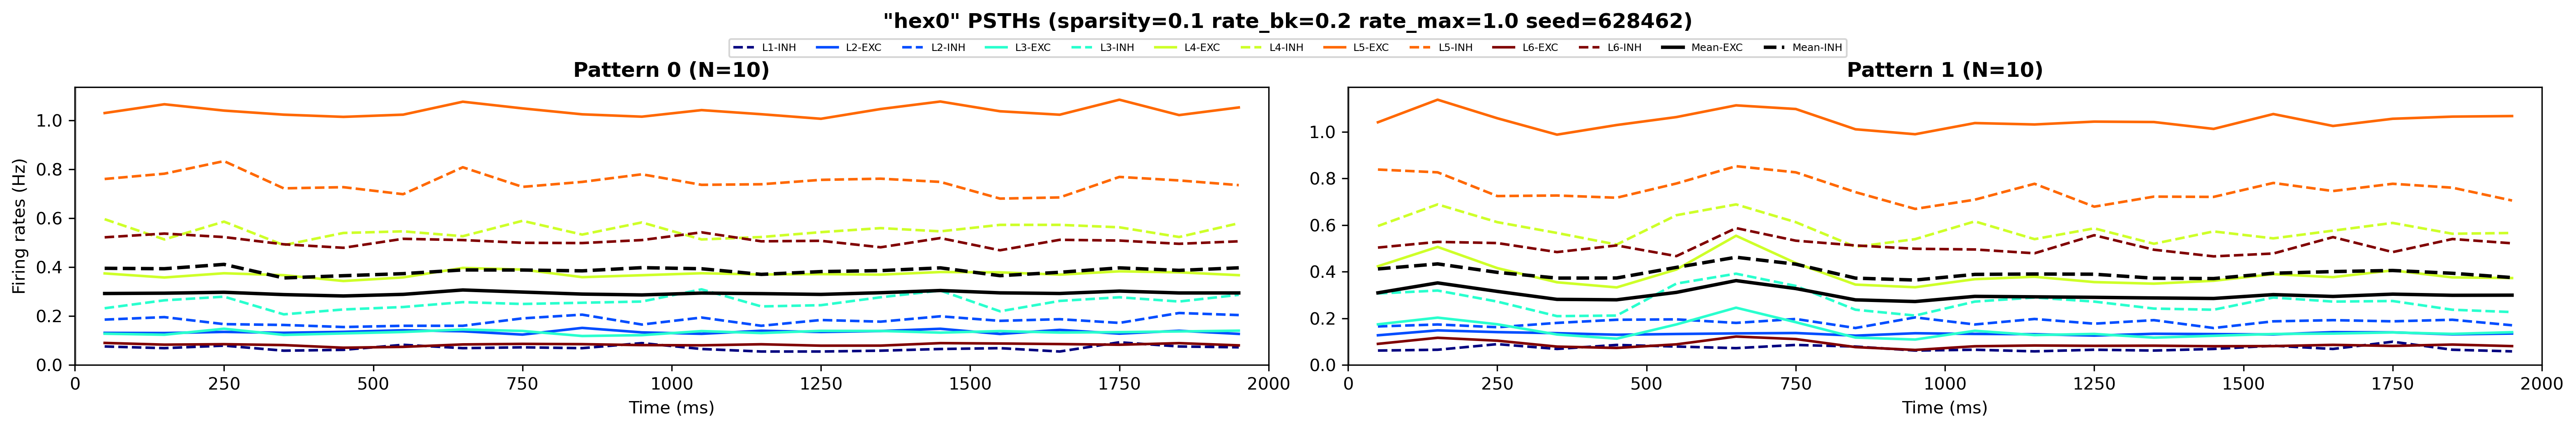

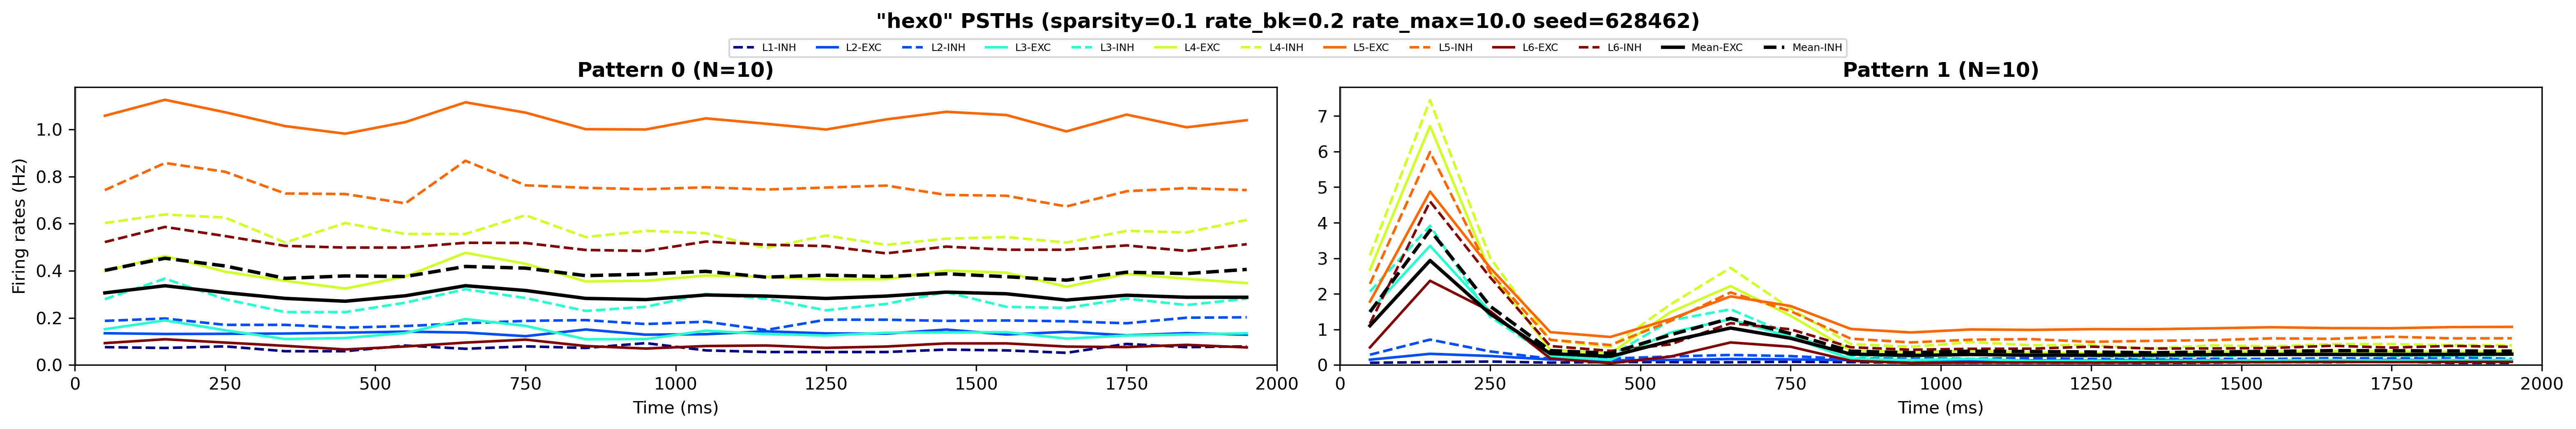

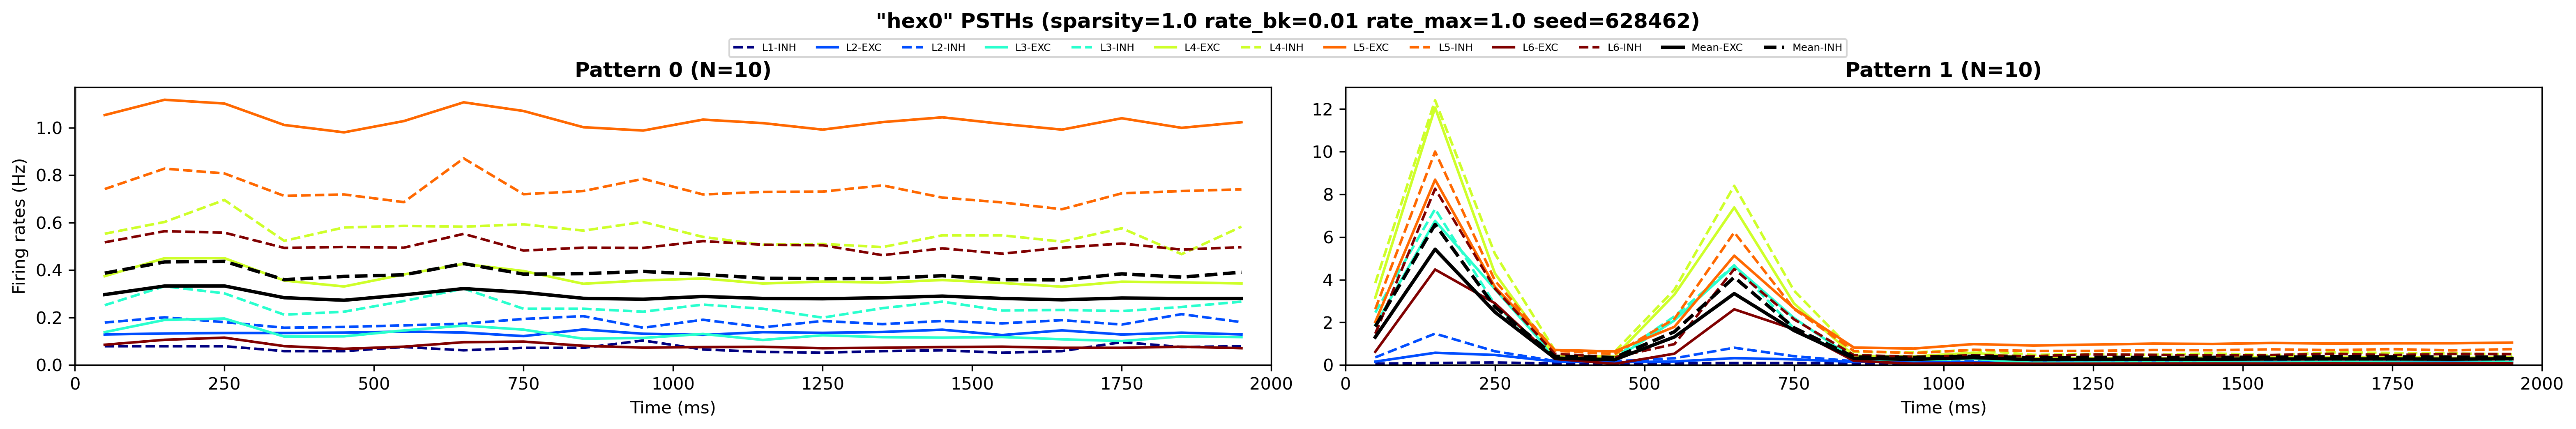

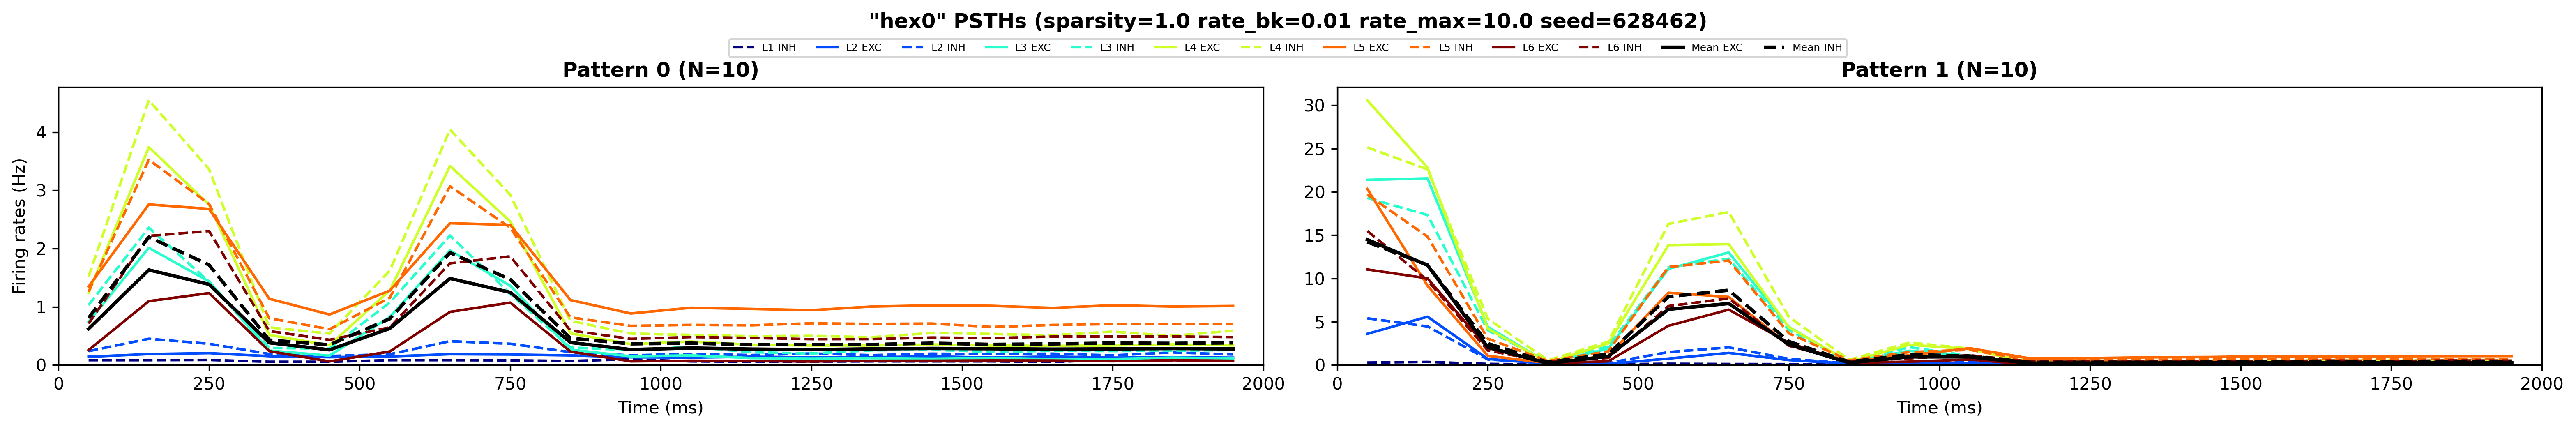

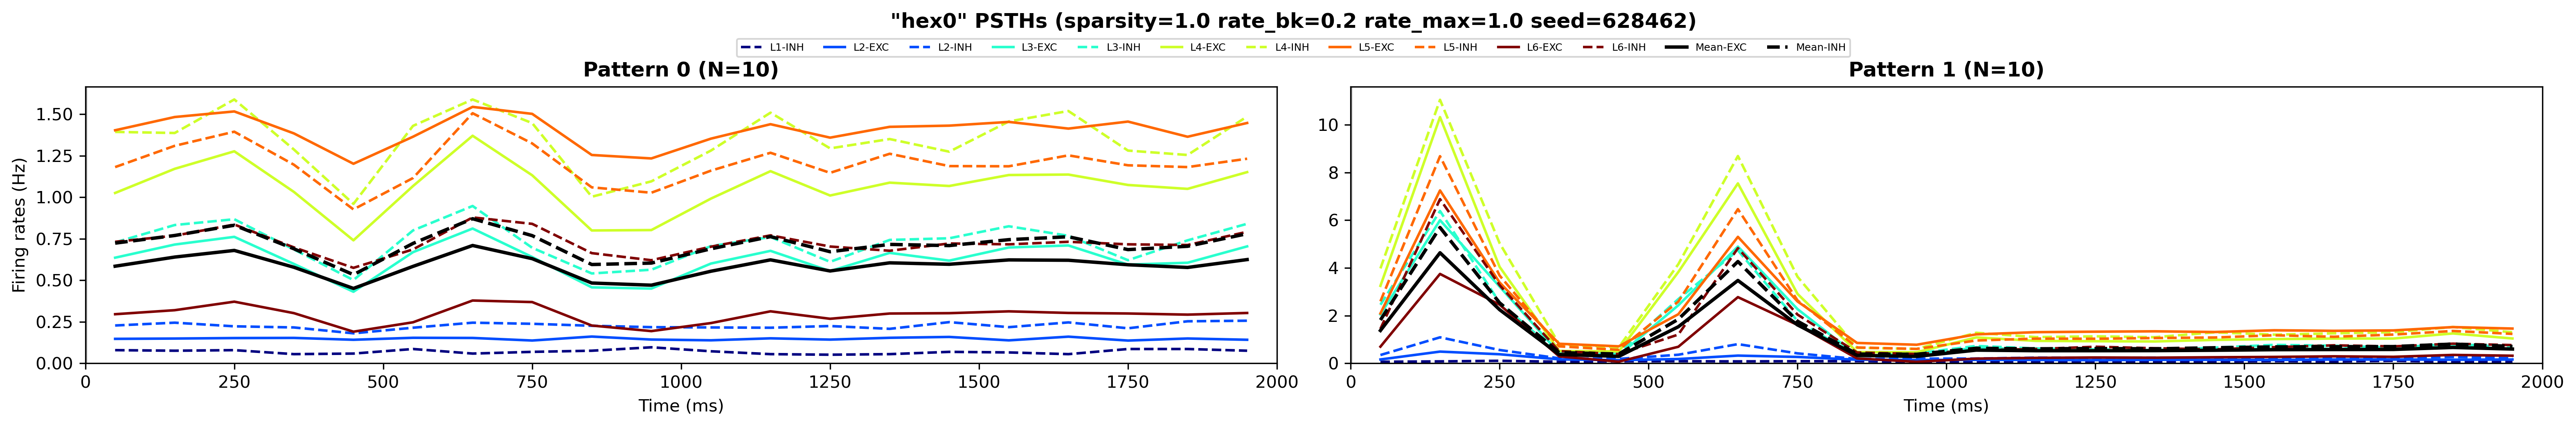

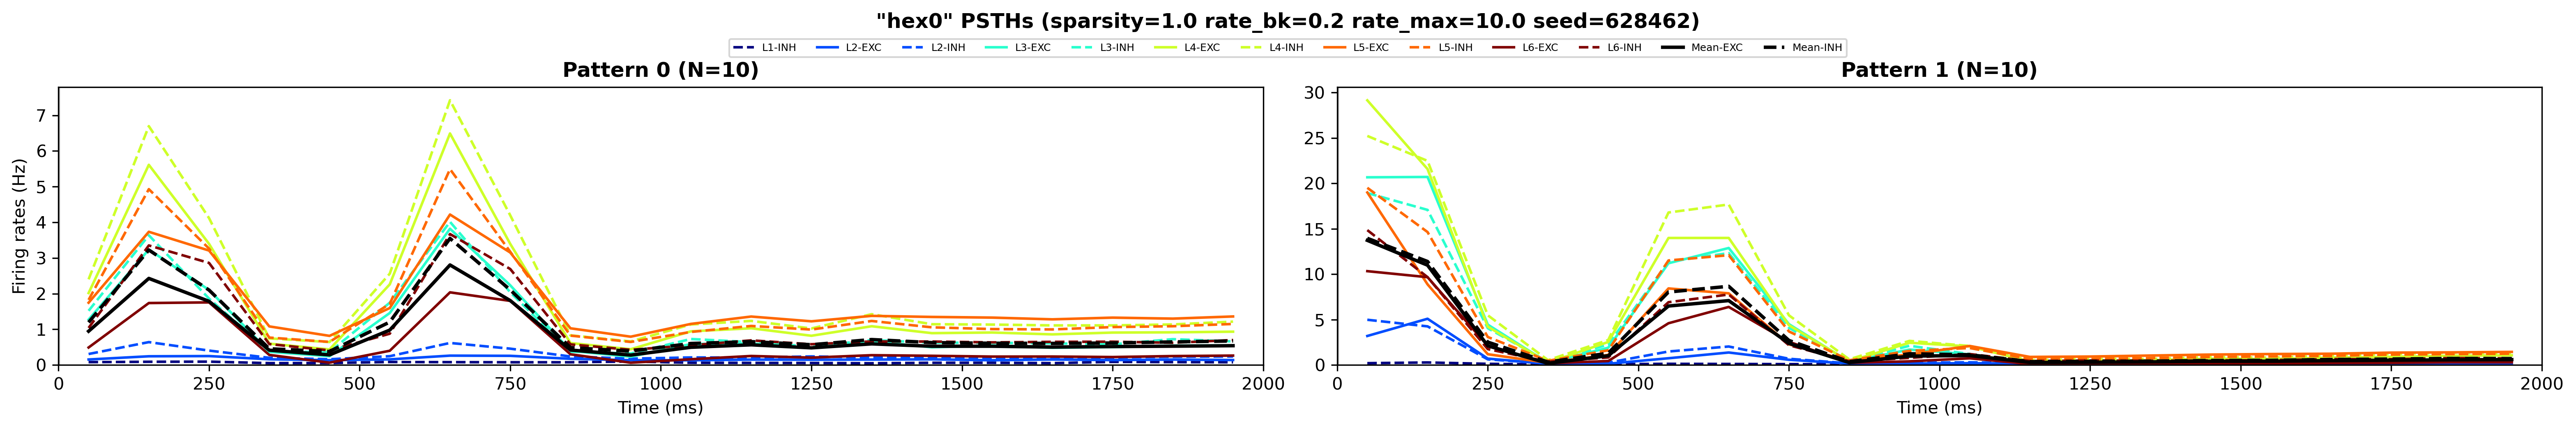

In [8]:
# Population PSTHs
for idx in [0, 4, 15, 19, 80, 84, 95, 99]:
    blue_config = sims.iloc[idx]
    plot_PSTH(blue_config, psth_bin_size=100, psth_interval=None, psth_target='hex0', label=' '.join([f'{i[0]}={i[1]}' for i in zip(sims.index.names, sims.index[idx])]), match_scale=False, save_fn=os.path.join(save_path, f'psth_{idx}.png'))

In [4]:
sim_sel = 99
cell_sel = {'synapse_class': 'EXC', 'layer': 4}
sel_spec = '_'.join([f'{k}{v}' for k, v in cell_sel.items()])
sel_spec = sel_spec.replace('synapse_class', '')
sel_spec = sel_spec.replace('layer', 'L')
sel_spec = f'SIM{sim_sel}_' + sel_spec
t_rate, rates, spike_trains, avg_cell_rates, stim_cfg, opto_cfg = get_single_cell_psths(sims.iloc[sim_sel], {'target': 'hex0', **cell_sel}, t_res=1.0, t_smooth=20.0)

INFO: No opto config found!


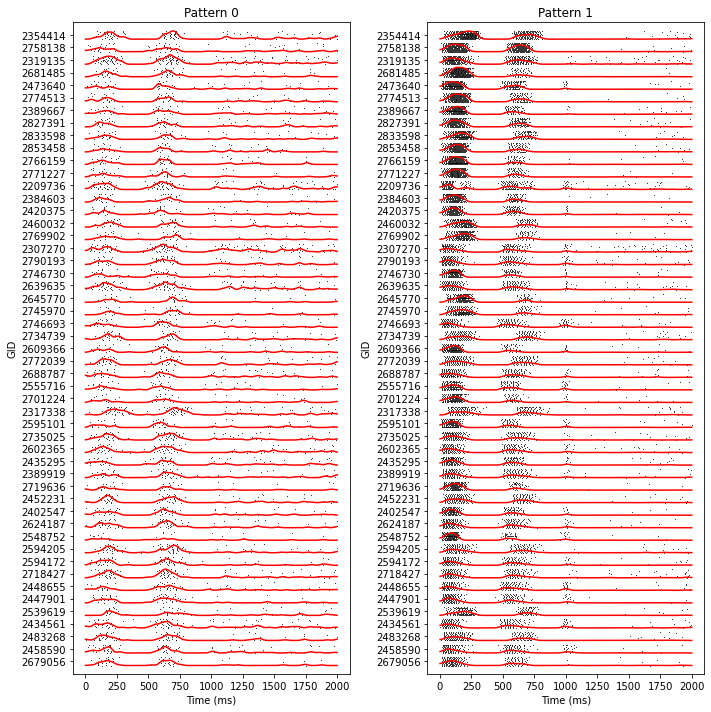

In [22]:
patt_sel = 1 # N patterns: 0..N-1 w/o opto, N..2N-1 with opto
rate_sel = (10.0, np.inf)
y_scale = 0.075

# Filter & sort GIDs by increasing firing rates
gids = np.array(list(spike_trains[patt_sel].keys()))
avg_rates_sel = np.array(avg_cell_rates[patt_sel])
sort_idx = np.argsort(avg_rates_sel)
gids = gids[sort_idx]
avg_rates_sel = avg_rates_sel[sort_idx]
sel_idx = np.logical_and(avg_rates_sel > rate_sel[0], avg_rates_sel < rate_sel[-1])
gids = gids[sel_idx] # Filter gids based on firing rates

plt.figure(figsize=(10, 10))
for p in range(2):
    rates_sel = rates[p]
    rates_sel = rates_sel[sort_idx, :]
    rates_sel = rates_sel[sel_idx, :]
    plt.subplot(1, 2, p + 1)
    for gidx, gid in enumerate(gids):
        trials = spike_trains[p][gid]
        for trial, st in enumerate(trials):
            plt.plot(st, np.full(len(st), (trial - 0.5 * (len(trials) - 1)) * y_scale + gidx), '.k', markersize=2.0, markeredgecolor='none')
        plt.plot(t_rate, gidx - y_scale * 0.5 * (len(trials) - 1) + y_scale * len(trials) * rates_sel[gidx, :] / np.max(rates_sel), 'r-')
    plt.yticks(np.arange(len(gids)), gids)
    plt.ylim((-1, len(gids)))
    plt.xlabel('Time (ms)')
    plt.ylabel('GID')
    plt.title(f'Pattern {p}')
plt.tight_layout()
plt.savefig(os.path.join(save_path, f'psth_spikes_{sel_spec}.png'), dpi=300)
plt.show()

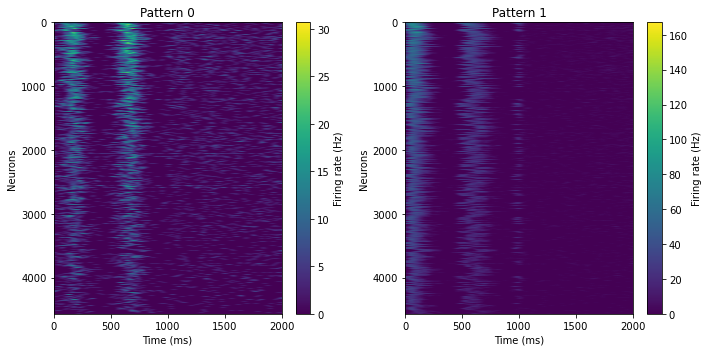

In [54]:
# Plot instantaneous firing rates (overview map)
plt.figure(figsize=(10, 5))
t_res = np.median(np.diff(t_rate))
for p in range(2):
    plt.subplot(1, 2, p + 1)
    plt.imshow(rates[p][np.flip(sort_idx), :], extent=(t_rate[0] - 0.5 * t_res, t_rate[-1] + 0.5 * t_res, rates[p].shape[0] - 0.5, -0.5), aspect='auto', interpolation='nearest')
    plt.colorbar(label='Firing rate (Hz)')
    plt.xlabel('Time (ms)')
    plt.ylabel('Neurons')
    plt.title(f'Pattern {p}')
plt.tight_layout()
plt.savefig(os.path.join(save_path, f'psth_rates_{sel_spec}.png'), dpi=300)
plt.show()

In [17]:
# Peak detection (first & second peak)
peak_idx, t1, t2, r1, r2, peak_ratio = detect_rate_peaks(t_rate, rates_sel, peak_th=20.0, peak_width=20.0, peak_distance=200.0)

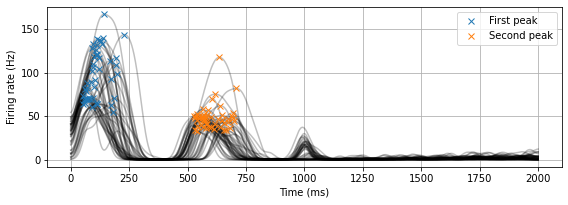

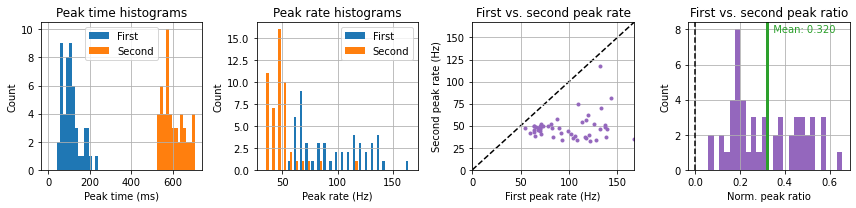

In [18]:
# Plot instantaneous firing rates inkl. peaks (selected GIDs)
plt.figure(figsize=(8, 3))
plt.plot(t_rate, rates_sel.T, 'k', alpha=0.25)
for idx in range(len(peak_idx)):
    plt.plot(t1[idx], r1[idx], 'x', color='tab:blue', alpha=1.0, label='First peak' if idx == 0 else None)
    plt.plot(t2[idx], r2[idx], 'x', color='tab:orange', alpha=1.0, label='Second peak' if idx == 0 else None)
plt.grid()
plt.xlabel('Time (ms)')
plt.ylabel('Firing rate (Hz)')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(save_path, f'psth_rate_peaks_{sel_spec}.png'), dpi=300)
plt.show()

# Plot first vs. second peak
plt.figure(figsize=(12, 3))
plt.subplot(1, 4, 1)
num_bins = 50
plt.hist(t1, bins=np.linspace(0, np.nanmax([t1, t2]), num_bins + 1), width=1.0 * np.nanmax([t1, t2]) / num_bins, label='First')
plt.hist(t2, bins=np.linspace(0, np.nanmax([t1, t2]), num_bins + 1), width=1.0 * np.nanmax([t1, t2]) / num_bins, label='Second')
plt.grid()
plt.xlabel('Peak time (ms)')
plt.ylabel('Count')
plt.title('Peak time histograms')
plt.legend()

plt.subplot(1, 4, 2)
num_bins = 25
plt.hist([r1, r2], bins=num_bins, label=['First', 'Second'])
plt.grid()
plt.xlabel('Peak rate (Hz)')
plt.ylabel('Count')
plt.title('Peak rate histograms')
plt.legend()

plt.subplot(1, 4, 3)
plt.plot(r1, r2, '.', color='tab:purple')
plt.xlim([0, np.nanmax([r1, r2])])
plt.ylim([0, np.nanmax([r1, r2])])
plt.plot([min(plt.xlim()), max(plt.xlim())], [min(plt.ylim()), max(plt.ylim())], '--k', zorder=0)
plt.grid()
plt.xlabel('First peak rate (Hz)')
plt.ylabel('Second peak rate (Hz)')
plt.title('First vs. second peak rate')

plt.subplot(1, 4, 4)
num_bins = 25
plt.hist(peak_ratio, bins=num_bins, color='tab:purple')
plt.ylim(plt.ylim())
plt.plot(np.zeros(2), plt.ylim(), '--k')
plt.plot(np.full(2, np.nanmean(peak_ratio)), plt.ylim(), '-', color='tab:green', linewidth=3)
plt.text(np.nanmean(peak_ratio), 0.99 * max(plt.ylim()), f'  Mean: {np.nanmean(peak_ratio):.3f}', color='tab:green', ha='left', va='top')
plt.grid()
plt.xlabel('Norm. peak ratio')
plt.ylabel('Count')
plt.title('First vs. second peak ratio')

plt.tight_layout()
plt.savefig(os.path.join(save_path, f'psth_peak_stats_{sel_spec}.png'), dpi=300)
plt.show()

In [49]:
# Now re-run for all simulations (using same set of GIDs)
peak_ratios = []
for sim in range(sims.shape[0]):
    t_rate, rates, spike_trains, avg_cell_rates, stim_cfg, opto_cfg = get_single_cell_psths(sims.iloc[sim], {'target': 'hex0', **cell_sel}, t_res=1.0, t_smooth=20.0)
    rates_sel = rates[patt_sel]
    rates_sel = rates_sel[sort_idx, :]
    rates_sel = rates_sel[sel_idx, :]
    peak_idx, t1, t2, r1, r2, peak_ratio = detect_rate_peaks(t_rate, rates_sel, peak_th=1.0, peak_width=50.0, peak_distance=200.0)
    peak_ratios.append(np.nanmean(peak_ratio))

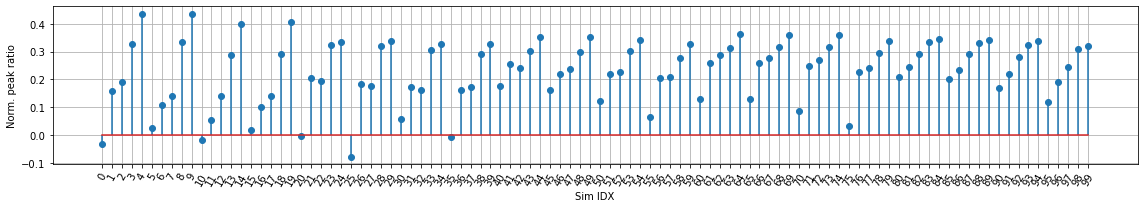

In [72]:
plt.figure(figsize=(16, 3))
plt.stem(np.arange(len(peak_ratios)), peak_ratios)
plt.xticks(np.arange(len(peak_ratios)), rotation=60)
plt.xlabel('Sim IDX')
plt.ylabel('Norm. peak ratio')
plt.grid()

plt.tight_layout()
plt.savefig(os.path.join(save_path, f'sim_peak_ratios_{"_".join(sel_spec.split("_")[1:])}.png'), dpi=300)
plt.show()

In [ ]:
# TODO => Characterization of grating stimulus responses:
# * Select set of (EXC/INH) cells, (strongly) responding to max. contrast
# * For each single cell, characterize responses:
#   - From instantaneous rates: Peak rates of 1st (highest) peak => To select stimulus parameters
#   - From instantaneous rates: Ratio of 1st (highest) vs. 2nd (2nd highest) peak rates => To select stimulus parameters
#     => MORE ROBUST by selecting first two HIGHEST peaks??
#     => LOOK AT medium/low responding cells as well
#     => PLOT 1st AND 2nd peak rate vs. Sim IDX
#   - Average rate over blank intervals => Baseline
#   - Average rate over stim intervals (different contrast) => Tuning curves (control, i.e. w/o opto stim)
#
# * For INH cells, check if/why shape of (PV) response is different from [Shapiro et al. 2021]